# Predicting NBA Player Award winners with Machine Learning

The goal of this analysis is to predict NBA Player Awards winners for a specific year by applying machine learning algorithms on player performance data and award voting data from other years. Player Awards considered in this analysis are [Most Valuable Player](https://www.basketball-reference.com/awards/mvp.html) (MVP), [Rookie of the Year](https://www.basketball-reference.com/awards/roy.html) (ROY), [Defensive Player of the Year](https://www.basketball-reference.com/awards/dpoy.html) (DPOY) and [Sixth Man of the Year](https://www.basketball-reference.com/awards/smoy.html) (SMOY). The analysis is based on the [Scikit-learn](http://scikit-learn.org) machine learning package, NBA data are taken from [basketball-reference.com](https://www.basketball-reference.com).

## Import modules and libraries:

In [1]:
import NBAanalysissetup # See NBAanalysissetup.py

from NBAanalysissetup import MyModel, MyCM

import matplotlib.pyplot as plt
import numpy             as np
import pandas            as pd
import seaborn           as sns

import operator
import time

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

from sklearn.neighbors        import KNeighborsRegressor
from sklearn.linear_model     import Ridge, Lasso, ElasticNet, SGDRegressor, PassiveAggressiveRegressor
from sklearn.linear_model     import RidgeCV, LassoCV, ElasticNetCV
from sklearn.svm              import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.tree             import DecisionTreeRegressor
from sklearn.ensemble         import RandomForestRegressor, ExtraTreesRegressor 
from sklearn.ensemble         import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neural_network   import MLPRegressor

from xgboost                  import XGBRegressor

from sklearn.model_selection import validation_curve, LeaveOneGroupOut, GridSearchCV

from sklearn.metrics import explained_variance_score, median_absolute_error, mean_absolute_error 
from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score

import ipywidgets

from bokeh.models   import ColumnDataSource, LabelSet, HoverTool
from bokeh.plotting import figure
from bokeh.io       import output_notebook, push_notebook, show

output_notebook() # to enable Bokeh for Jupyter

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

%load_ext watermark
%watermark -a "Author: gmalim" 
print("")
%watermark -u -n
print("")
%watermark -v -p numpy,pandas,sklearn,xgboost,matplotlib,seaborn
print("")
%watermark -m

start = time.time()

Loading BokehJS ...

Author: gmalim

last updated: Wed May 02 2018

CPython 3.6.5
IPython 6.3.1

numpy 1.14.3
pandas 0.22.0
sklearn 0.19.1
xgboost 0.71
matplotlib 2.2.2
seaborn 0.8.1

compiler   : GCC 4.2.1 Compatible Apple LLVM 8.0.0 (clang-800.0.42.1)
system     : Darwin
release    : 15.6.0
machine    : x86_64
processor  : i386
CPU cores  : 2
interpreter: 64bit


## User input

Choose the NBA Player Award you want to predict:
- Most Valuable Player (MVP)
- Rookie of the Year (ROY)
- Defensive Player of the Year (DPOY)
- Sixth Man of the Year (SMOY)

In [2]:
awards = {1:'MVP', 2:'ROY', 3:'DPOY', 4:'SMOY'}

award = awards[1] # Enter an integer from the awards dict

print("--> Player Award used in analysis: {}".format(award))

--> Player Award used in analysis: MVP


Enter the first and last year for which data has been scraped, and choose the year you want to predict. The years that are not selected are used for cross-validation and training of the ML algorithms. NBA data from 2000-2018 from [basketball-reference.com](https://www.basketball-reference.com) have been saved as csv-files in the [data](data) directory of this repository using the scraper functions in [*NBAanalysissetup.py*](NBAanalysissetup.py). Data from other years can be obtained by using [*Basketball_Reference_scraper.py*](Basketball_Reference_scraper.py).

In [3]:
first_year = 2000 # Enter first year for which data has been scraped
last_year  = 2017 # Enter last year for which data has been scraped
test_year  = 2017 # Enter any year for which data has been scraped

#%store -r test_year # get test_year that was stored in another notebook

# Check if award has been awarded yet for test_year:
 
shellcommand = "wc -l data/NBA_{}_{}-{}.csv | awk '{{print $1}}'".format(award, test_year-1, test_year)
n = !{shellcommand}
n = int(n[0])
test_year_truth_is_known = False if n == 1 else True

if test_year_truth_is_known:
    print("--> Test year = {} ({} has been awarded)".format(test_year, award))
else:
    print("--> Test year = {} ({} has not been awarded yet)".format(test_year, award))
    
train_years = list(range(first_year, last_year+1))
train_years.remove(test_year)

first_train_year = train_years[0]
last_train_year  = train_years[-1]
    
if (first_train_year < test_year < last_train_year):
    print("--> Train years = {}-{} except {}".format(first_train_year, last_train_year, test_year))
else:
    print("--> Train years = {}-{}".format(first_train_year, last_train_year))

--> Test year = 2017 (MVP has been awarded)
--> Train years = 2000-2016


Choose whether you want to include advanced players statistics (e.g. *PER*, *VORP*, etc.) in the model or not:

In [4]:
includeadvancedstats = True # Enter True or False

if includeadvancedstats:
    print("--> Advanced statistics included")
else:
    print("--> Advanced statistics not included")

--> Advanced statistics included


Choose the minimum number of games a player has to have played (ROY, SMOY) or started (MVP, DPOY) per season to be included in the analysis:

In [5]:
min_num_games = 60 # Enter an integer between 0 and 82

print("--> Minimum number of games =", min_num_games)

--> Minimum number of games = 60


## Data processing

Load NBA player performance data and Player Award voting data into dataframes:

In [6]:
df_train, df_test = NBAanalysissetup.loaddata_allyears(train_years, test_year, includeadvancedstats, target=award)

--> Loading train year 1999-2000 ...
--> Loading train year 2000-2001 ...
--> Loading train year 2001-2002 ...
--> Loading train year 2002-2003 ...
--> Loading train year 2003-2004 ...
--> Loading train year 2004-2005 ...
--> Loading train year 2005-2006 ...
--> Loading train year 2006-2007 ...
--> Loading train year 2007-2008 ...
--> Loading train year 2008-2009 ...
--> Loading train year 2009-2010 ...
--> Loading train year 2010-2011 ...
--> Loading train year 2011-2012 ...
--> Loading train year 2012-2013 ...
--> Loading train year 2013-2014 ...
--> Loading train year 2014-2015 ...
--> Loading train year 2015-2016 ...
--> Loading test  year 2016-2017 ...


Print table of players with award votes in *test_year*:

In [7]:
if test_year_truth_is_known:
    print("--> Players with {} votes in {} :".format(award, test_year))
    #df_tmp = df_train[(df_train['YEAR'] == print_year) & (df_train['G'] > 81)]
    df_tmp = df_test[df_test['AVS'] > 0]
    cm = sns.diverging_palette(240, 10, n=9, as_cmap=True)
    df_tmp_style = df_tmp.style.background_gradient(cmap=cm, axis=0)
    display(df_tmp_style)
else:
    print("--> The NBA {} for {} has not been awarded yet".format(award, test_year))

--> Players with MVP votes in 2017 :


,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,TW,TC,AVS,YEAR
15,Giannis Antetokounmpo,SF,22,MIL,80,80,2845,656,1259,0.521,49,180,0.272,607,1079,0.563,0.541,471,612,0.77,142,558,700,434,131,151,234,246,1832,26.1,0.599,0.143,0.486,5.9,22.6,14.3,26.6,2.3,4.7,13.3,28.3,7.9,4.5,12.4,0.21,4.1,3.5,7.6,6.9,42,EC,0.007,2017
97,Stephen Curry,PG,28,GSW,79,79,2638,675,1443,0.468,324,789,0.411,351,654,0.537,0.58,325,362,0.898,61,292,353,524,142,17,239,183,1999,24.6,0.624,0.547,0.251,2.7,11.4,7.3,31.2,2.6,0.5,13,30.1,8.7,3.9,12.6,0.229,7.8,-0.4,7.3,6.2,67,WC,0.051,2017
99,Anthony Davis,C,23,NOP,75,75,2708,770,1526,0.505,40,134,0.299,730,1392,0.524,0.518,519,647,0.802,172,712,884,157,94,167,181,168,2099,27.5,0.58,0.088,0.424,6.7,27.9,17.2,11.1,1.7,5.1,9.1,32.6,5.9,5.1,11,0.195,1.4,2.3,3.7,3.9,34,WC,0.002,2017
107,DeMar DeRozan,SG,27,TOR,74,74,2620,721,1545,0.467,33,124,0.266,688,1421,0.484,0.477,545,647,0.842,70,316,386,290,78,13,180,134,2020,24,0.552,0.08,0.419,3,13.6,8.3,20.6,1.5,0.4,9,34.3,6.7,2.4,9,0.166,2.4,-1.5,0.9,1.9,51,EC,0.001,2017
118,Kevin Durant,PF,28,GSW,62,62,2070,551,1026,0.537,117,312,0.375,434,714,0.608,0.594,336,384,0.875,39,474,513,300,66,99,138,117,1555,27.6,0.651,0.304,0.374,2.2,23.6,13.6,23.1,1.5,3.8,10.4,27.8,8,4,12,0.278,5.4,2.6,8,5.2,67,WC,0.002,2017
171,James Harden,PG,27,HOU,81,81,2947,674,1533,0.44,262,756,0.347,412,777,0.53,0.525,746,881,0.847,95,564,659,907,121,38,464,215,2356,27.4,0.613,0.493,0.575,3.5,20.9,12.2,50.7,2,1,19.5,34.2,11.5,3.6,15,0.245,8.7,1.5,10.1,9,55,WC,0.746,2017
219,LeBron James,SF,32,CLE,74,74,2794,736,1344,0.548,124,342,0.363,612,1002,0.611,0.594,358,531,0.674,97,542,639,646,92,44,303,134,1954,27,0.619,0.254,0.395,4,20.7,12.6,41.3,1.6,1.3,16.1,30,9.8,3,12.9,0.221,6.8,1.6,8.4,7.3,51,EC,0.33,2017
260,Kawhi Leonard,SF,25,SAS,74,74,2474,636,1312,0.485,147,387,0.38,489,925,0.529,0.541,469,533,0.88,80,350,430,260,133,55,154,122,1888,27.6,0.61,0.295,0.406,3.7,15.7,9.8,18.9,2.7,1.8,9.1,31.1,8.9,4.7,13.6,0.264,6.4,1.5,7.9,6.2,61,WC,0.495,2017
423,Isaiah Thomas,PG,27,BOS,76,76,2569,682,1473,0.463,245,646,0.379,437,827,0.528,0.546,590,649,0.909,43,162,205,448,70,13,210,167,2199,26.5,0.625,0.439,0.441,1.9,7,4.4,32.5,1.4,0.4,10.7,34,10.9,1.6,12.5,0.234,8.7,-3.3,5.4,4.8,53,EC,0.08,2017
451,John Wall,PG,26,WAS,78,78,2836,647,1435,0.451,89,272,0.327,558,1163,0.48,0.482,422,527,0.801,59,267,326,831,157,49,322,151,1805,23.2,0.541,0.19,0.367,2.4,10.6,6.5,46.9,2.7,1.4,16.2,30.6,5.8,3,8.8,0.149,3.8,0.2,4.1,4.3,49,EC,0.007,2017


Select only players which have played/started at least *min_num_games* number of games in a season:

In [8]:
#print("--> # of players in train set =", df_train.shape[0])
#print("--> # of players in test  set =", df_test .shape[0])
#print("")

#df_train = df_train[df_train['AVS'] > 0]
#df_test  = df_test [df_test ['AVS'] > 0]

print("--> # of players in train set =", df_train.shape[0])
print("--> # of players in test  set =", df_test .shape[0])
print("")

if (award == 'ROY') or (award == 'SMOY'):
    df_train = df_train[df_train['G']  >= min_num_games]
    df_test  = df_test [df_test ['G']  >= min_num_games]
else:
    df_train = df_train[df_train['GS'] >= min_num_games]
    df_test  = df_test [df_test ['GS'] >= min_num_games]

print("--> # of players in train set =", df_train.shape[0])
print("--> # of players in test  set =", df_test .shape[0])

# Reset dataframe indices:

df_train = df_train.reset_index(drop=True)
df_test  = df_test .reset_index(drop=True)

--> # of players in train set = 7754
--> # of players in test  set = 486

--> # of players in train set = 1692
--> # of players in test  set = 101


NaN handling:

In [9]:
print("--> # of players with NaNs in train set =", df_train.shape[0] - df_train.dropna().shape[0])
print("--> # of players with NaNs in test  set =", df_test .shape[0] - df_test .dropna().shape[0])
print("")

# Replace NaNs with 0s in the following columns:

df_train[['FG%', '3P%', '2P%', 'FT%', 'eFG%']] = df_train[['FG%', '3P%', '2P%', 'FT%', 'eFG%']].fillna(value=0)
df_test [['FG%', '3P%', '2P%', 'FT%', 'eFG%']] = df_test [['FG%', '3P%', '2P%', 'FT%', 'eFG%']].fillna(value=0)

if (includeadvancedstats):
    df_train[['TS%', '3PAr', 'FTr']] = df_train[['TS%', '3PAr', 'FTr']].fillna(value=0)
    df_test [['TS%', '3PAr', 'FTr']] = df_test [['TS%', '3PAr', 'FTr']].fillna(value=0)

print("--> # of players with NaNs in train set =", df_train.shape[0] - df_train.dropna().shape[0])
print("--> # of players with NaNs in test  set =", df_test .shape[0] - df_test .dropna().shape[0])
print("")

# Remove remaining players with NaNs, if necessary:

if (df_train.shape[0] - df_train.dropna().shape[0] != 0):
    #print("--> Players in train set with NaNs:")
    #print(df_train[df_train.isnull().any(axis=1)])
    #print("")
    df_train.dropna(inplace=True)
    print("--> # of players with NaNs in train set =", df_train.shape[0] - df_train.dropna().shape[0])

if (df_test.shape[0] - df_test.dropna().shape[0] != 0):
    #print("--> Players in test set with NaNs:")
    #print(df_test[df_test.isnull().any(axis=1)])
    #print("")
    df_test.dropna(inplace=True)
    print("--> # of players with NaNs in test  set =", df_test.shape[0] - df_test.dropna().shape[0])
    
# Reset dataframe indices:

df_train = df_train.reset_index(drop=True)
df_test  = df_test .reset_index(drop=True)

--> # of players with NaNs in train set = 96
--> # of players with NaNs in test  set = 1

--> # of players with NaNs in train set = 0
--> # of players with NaNs in test  set = 0



Create Feature Matrix (*X*) and Target Vector (*y*) dataframes:

In [10]:
# Feature Matrix dataframes:

X_train = df_train.drop(['AVS', 'YEAR'], axis=1) # VS and YEAR are dropped: AVS is the target variable (see below),
X_test  = df_test .drop(['AVS', 'YEAR'], axis=1) # YEAR is only used for cross-validation (see CV section).

X_list = [X_train, X_test]

for X in X_list:
    
    # Remove redundant features:
    
    # - Features with no predictive power 
    # - Features that are correlated with other features
    # - Features that measure the same performance skill
    
    X.drop(['Player', 'Pos', 'Tm', 'Age', 'TC',     
            'FG', 'FGA', 'FG%', '2P', '2PA', '2P%', 
            '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%', 
            'ORB', 'DRB', 'PF'],                    
           axis=1, inplace=True)

    if includeadvancedstats:
        X.drop(['3PAr', 'FTr', 'ORB%', 'DRB%', 'TOV%', 'WS', 'WS/48', 'BPM', 
                'eFG%', 'TRB', 'AST', 'STL', 'BLK', 'TOV'], 
               axis=1, inplace=True) 
    
    # Scale total-type features by MP/48:
    
    X[['PTS']] = X[['PTS']].div(X['MP'].values, axis=0)
    X[['PTS']] = X[['PTS']].multiply(48, axis=0)
    X.rename(columns={'PTS': 'PTS/48'}, inplace=True)
    
    if includeadvancedstats:
        X[['OWS', 'DWS']] = \
        X[['OWS', 'DWS']].div(X['MP'].values, axis=0)
        X[['OWS', 'DWS']] = X[['OWS', 'DWS']].multiply(48, axis=0)
        X.rename(columns={'OWS': 'OWS/48', 'DWS': 'DWS/48'}, inplace=True)
    else:
        X[['TRB', 'AST', 'STL', 'BLK']] = X[['TRB', 'AST', 'STL', 'BLK']].div(X['MP'].values, axis=0)
        X[['TRB', 'AST', 'STL', 'BLK']] = X[['TRB', 'AST', 'STL', 'BLK']].multiply(48, axis=0)
        X.rename(columns={'TRB': 'TRB/48', 'AST': 'AST/48', 'STL': 'STL/48', 
                          'BLK': 'BLK/48', 'TOV': 'TOV/48'}, inplace=True)

    # Scale MP by G:

    X['MP'] = X['MP'].div(X['G'], axis=0)
    X.rename(columns={'MP': 'MP/G'}, inplace=True)
    
# Target Vector dataframes: 

y_train = df_train['AVS'] # target = AVS, a floating variable introduced to indicate players' award vote share
y_test  = df_test ['AVS']

n_players_train = X_train.shape[0]
n_players_test  = X_test .shape[0]
n_features = X_test.shape[1] # equals X_train.shape[1]

print("--> Train data set : # of players = {:4}, # of features = {}".format(n_players_train, n_features))
print("--> Test  data set : # of players = {:4}, # of features = {}".format(n_players_test,  n_features))

print("")
print("--> Model features : ", end = '')
print(*X_train.columns, sep=', ')

--> Train data set : # of players = 1692, # of features = 17
--> Test  data set : # of players =  101, # of features = 17

--> Model features : G, GS, MP/G, PTS/48, PER, TS%, TRB%, AST%, STL%, BLK%, USG%, OWS/48, DWS/48, OBPM, DBPM, VORP, TW


Plot Award Voting Share (AVS) distribution in training and test data:

--> # of players in train set with AVS > 0 = 237
--> # of players in test set with AVS > 0 = 11


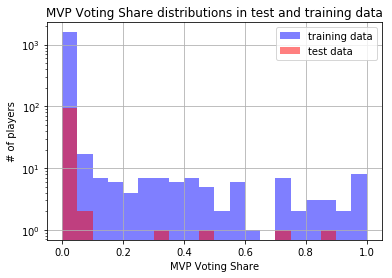

In [11]:
plt.figure(1)

plt.hist(y_train, range=(0, 1), bins=20, histtype="stepfilled", color='b', lw=2, alpha=0.5, label='training data')
if test_year_truth_is_known:
    plt.hist(y_test,  range=(0, 1), bins=20, histtype="stepfilled", color='r', lw=2, alpha=0.5, label='test data')
    
plt.xlabel("{} Voting Share".format(award))
plt.ylabel("# of players")
plt.yscale('log')
plt.grid(True)
if test_year_truth_is_known:
    plt.title("{} Voting Share distributions in test and training data".format(award))
    plt.legend(loc='upper right')
else:
    plt.title("{} Voting Share distribution in training data".format(award))

print("--> # of players in train set with AVS > 0 =", len(df_train[df_train['AVS'] > 0]))
if test_year_truth_is_known:
    print("--> # of players in test set with AVS > 0 =", len(df_test [df_test ['AVS'] > 0]))

Explore relationship between AVS and other features in training data:

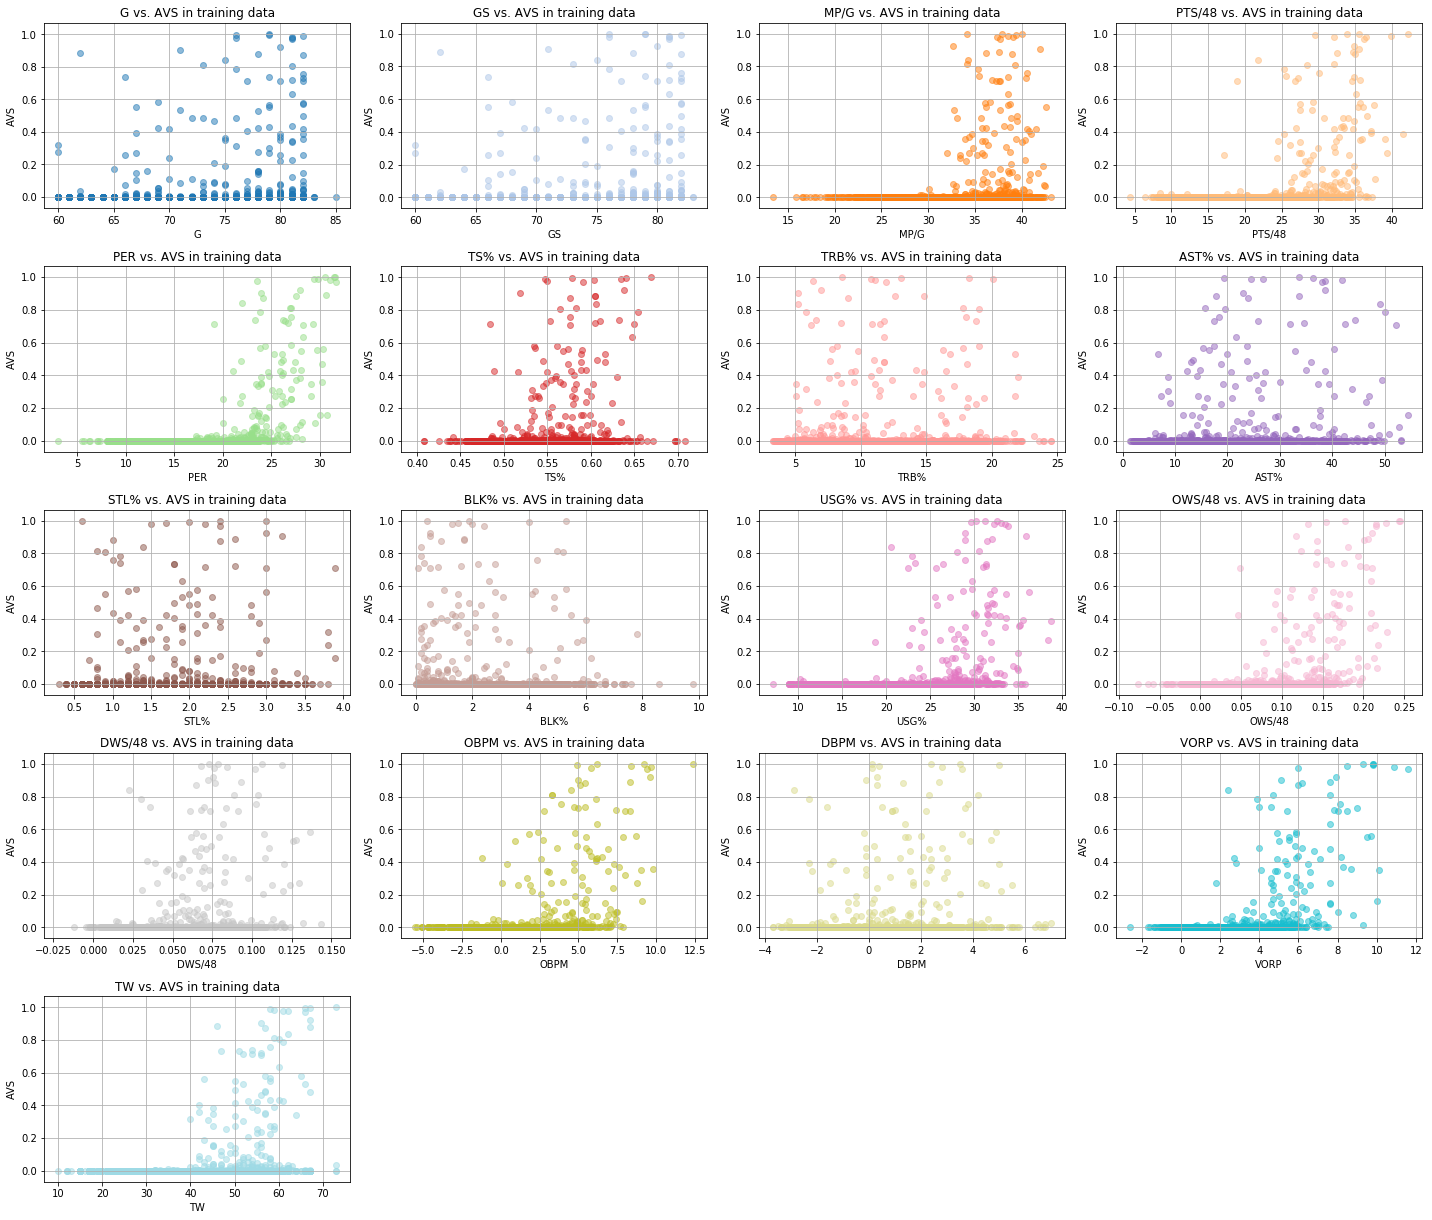

In [12]:
color=iter(plt.cm.tab20(np.linspace(0, 1, len(X_train.columns))))    

plt.figure(figsize=(20, 20))

for ifeature, feature in enumerate(X_train.columns):

    plt.subplot(6, 4, ifeature+1)

    plt.title("{} vs. AVS in training data".format(feature))
    plt.xlabel(feature)
    plt.ylabel('AVS')
    plt.scatter(X_train[feature], y_train, color=next(color), alpha=0.5)
    plt.grid(True)
    plt.tight_layout()

Scale feature dataframes to accommodate ML algorithms:

In [13]:
feature_names = X_train.columns # This is no longer available after transformation with scaler

#X_scaler = StandardScaler(with_mean=True, with_std=True) # Scaler with zero mean and unit variance
#X_scaler = MinMaxScaler() # Scales features to range 0 to 1 (or -1 to 1 if there are negative values)
X_scaler = RobustScaler() # Similar method to the MinMaxScaler but more robust to outliers

X_train = X_scaler.fit_transform(X_train) # Fit scaler to training data and transform X_train
X_test  = X_scaler.transform(X_test)      # Transform X_test using fitted scaler

## Supervised Learning

Select ML regressors, set hyper-parameters and instantiate models:

In [14]:
rseed = 666 # Set random_state of model (where applicable) to specific seed, to tune hyper-parameters

models = []

estimator_name = 'K-Nearest Neighbours Regressor'
n_n = 5
w   = 'uniform' # 'uniform', 'distance'
estimator = KNeighborsRegressor(n_neighbors=n_n, weights=w)
models.append(MyModel(estimator_name, estimator))

estimator_name = 'Ridge Regressor' # Shrinkage => Feature coefficient suppression
a = 0.1 # regularization factor (higher alpha -> stronger regularization i.e. opposite of C parameter)
estimator = Ridge(alpha=a, random_state=rseed)
models.append(MyModel(estimator_name, estimator))

estimator_name = 'Lasso Regressor' # Sparsity => Feature selection
a = 1e-05
estimator = Lasso(alpha=a, random_state=rseed)
models.append(MyModel(estimator_name, estimator))

estimator_name = 'ElasticNet Regressor' # Shrinkage & Sparsity
a = 1e-04
l_r = 0.5
estimator = ElasticNet(alpha=a, l1_ratio=l_r, random_state=rseed)
models.append(MyModel(estimator_name, estimator))

estimator_name = 'Support Vector Machine Regressor'
#estimator_name = 'Linear Support Vector Machine Regressor'
C = 0.1
e = 0.1
k = 'poly' # 'linear'
d = 3 # only used by poly kernel
estimator = SVR(C=C, epsilon=e, kernel=k, degree=d, cache_size=4000)
#l = 'epsilon_insensitive' # i.e. l1 regularizarion -> Sparsity
#l = 'squared_epsilon_insensitive' # i.e. l2 regularizarion -> Shrinkage 
#estimator = LinearSVR(C=C, loss=l, dual=False, random_state=rseed)
models.append(MyModel(estimator_name, estimator))

estimator_name = 'Stochastic Gradient Descent Regressor'
l = 'squared_loss' # 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'
p = 'l2' # 'l1', 'elasticnet'
a = 0.01
l_r = 0.15 # only for elasticnet penalty
estimator = SGDRegressor(loss=l, penalty=p, alpha=a, l1_ratio=l_r, random_state=rseed)
models.append(MyModel(estimator_name, estimator))

estimator_name = 'Passive Aggressive Regressor'
C = 0.001
l = 'epsilon_insensitive' # 'squared_epsilon_insensitive'
e = 0.1
estimator = PassiveAggressiveRegressor(C=C, loss=l, epsilon=e, random_state=rseed)
models.append(MyModel(estimator_name, estimator))

estimator_name = 'Neural Network Regressor'
a = 1.0 # l2 regularization factor
estimator = MLPRegressor(alpha=a, #hidden_layer_sizes=(100, 100, 100, 100, 100), 
                          activation='relu', solver='adam', random_state=rseed)
models.append(MyModel(estimator_name, estimator))

estimator_name = 'Gaussian Process Regressor' # (CV is slowwwwwwww)
estimator = GaussianProcessRegressor(random_state=rseed)
models.append(MyModel(estimator_name, estimator))

estimator_name = 'Decision Tree Regressor'
m_d = None   # i.e. nodes are expanded until leafs are pure 
m_f = 'auto' # The number of features to consider when looking for the best split. 
#              'auto' => max_features=n_features 
estimator = DecisionTreeRegressor(max_depth=m_d, max_features=m_f, random_state=rseed)
models.append(MyModel(estimator_name, estimator))

estimator_name = 'Random Forest Regressor'
n_e = 100
m_d = None
m_f = 'auto'
estimator = RandomForestRegressor(n_estimators=n_e, max_depth=m_d, max_features=m_f, random_state=rseed)
models.append(MyModel(estimator_name, estimator))

estimator_name = 'Extra Randomized Trees Regressor'
n_e = 100
m_d = None
m_f = 'auto'
estimator = ExtraTreesRegressor(n_estimators=n_e, max_depth=m_d, max_features=m_f, random_state=rseed)
models.append(MyModel(estimator_name, estimator))

estimator_name = 'Adaptive Boosted Decision Tree Regressor'
n_e = 100
l_r = 0.1
estimator = AdaBoostRegressor(n_estimators=n_e, learning_rate=l_r, random_state=rseed)
models.append(MyModel(estimator_name, estimator))

estimator_name = 'Gradient Boosted Decision Tree Regressor'
n_e = 100
m_d = 3
l_r = 0.1
estimator = GradientBoostingRegressor(n_estimators=n_e, max_depth=m_d, learning_rate=l_r, random_state=rseed)
models.append(MyModel(estimator_name, estimator))

estimator_name = 'Extreme Gradient Boosted Decision Tree Regressor'
n_e = 100
m_d = 3
l_r = 0.1
estimator = XGBRegressor(n_estimators=n_e, max_depth=m_d, learning_rate=l_r, random_state=rseed)
models.append(MyModel(estimator_name, estimator))

print("--> ML regressors implemented in this analysis:")
print("")

model_names = []

for counter, model in enumerate(models, 0):
    print("{:2} : {}".format(counter, model.estimator_name))
    #print("     Model parameters : ", mymodel.estimator.get_params())
    model_names.append(model.estimator_name)

--> ML regressors implemented in this analysis:

 0 : K-Nearest Neighbours Regressor
 1 : Ridge Regressor
 2 : Lasso Regressor
 3 : ElasticNet Regressor
 4 : Support Vector Machine Regressor
 5 : Stochastic Gradient Descent Regressor
 6 : Passive Aggressive Regressor
 7 : Neural Network Regressor
 8 : Gaussian Process Regressor
 9 : Decision Tree Regressor
10 : Random Forest Regressor
11 : Extra Randomized Trees Regressor
12 : Adaptive Boosted Decision Tree Regressor
13 : Gradient Boosted Decision Tree Regressor
14 : Extreme Gradient Boosted Decision Tree Regressor


## Cross-validation

Cross-validate the model using training data and the *LeaveOneGroupOut* cross-validation scheme in which a group is defined as a single NBA season.

In [15]:
logo = LeaveOneGroupOut()

cv_groups = df_train['YEAR'] # Players in the same group (i.e. a single NBA season) have identical YEAR variables

Use *GridSearchCV* to tune hyperparameters:

Calculate and plot validation curves for specific models:

--> Plotting validation curves for Ridge Regressor ...


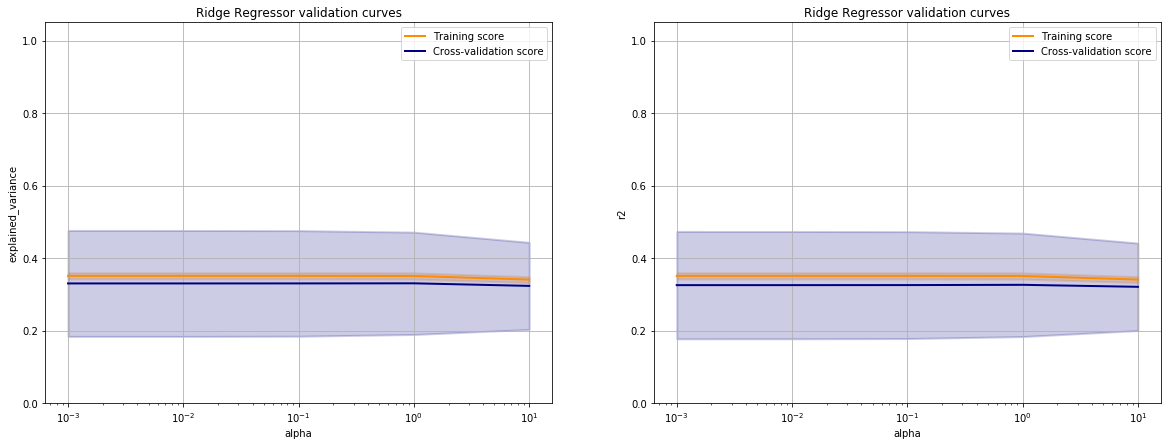

In [16]:
model = models[1]

regressor = model.estimator

print("--> Plotting validation curves for", model.estimator_name, "...")

min_logspace = -3
max_logspace =  1
param_range = np.logspace(min_logspace, max_logspace, (abs(min_logspace)+abs(max_logspace)+1))
#param_range = [2,4,6,8,10] #[3, 7, 11, 15]
#param_name = 'n_neighbors'
param_name = 'alpha'
#param_name = 'C'
#param_name = 'epsilon'
#param_name = 'max_depth'

plt.figure(figsize=(20, 7))

plt.subplot(1, 2, 1)

scoring_metric = 'explained_variance'

cv_logo = logo.split(X_train, y_train, groups=cv_groups)

train_scores, test_scores = validation_curve(regressor, X_train, y_train, param_name=param_name, n_jobs=-1,
                                             param_range=param_range, cv=cv_logo, scoring=scoring_metric)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std  = np.std (train_scores, axis=1)
test_scores_mean  = np.mean(test_scores,  axis=1)
test_scores_std   = np.std (test_scores,  axis=1)

plt.title("{} validation curves".format(model.estimator_name))
plt.xlabel(param_name)
plt.ylabel(scoring_metric)
plt.ylim(0.0, 1.05)
plt.semilogx(param_range, train_scores_mean, label="Training score", color="darkorange", lw=2)
#plt.plot(param_range, train_scores_mean, label="Training score", color="darkorange", lw=2)
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, 
                 alpha=0.2, color="darkorange", lw=2)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=2)
#plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=2)
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, 
                 alpha=0.2, color="navy", lw=2)
plt.grid(True)
plt.legend(loc="best");

plt.subplot(1, 2, 2)

scoring_metric = 'r2'

cv_logo = logo.split(X_train, y_train, groups=cv_groups)

train_scores, test_scores = validation_curve(regressor, X_train, y_train, param_name=param_name, n_jobs=-1,
                                             param_range=param_range, cv=cv_logo, scoring=scoring_metric)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std  = np.std (train_scores, axis=1)
test_scores_mean  = np.mean(test_scores,  axis=1)
test_scores_std   = np.std (test_scores,  axis=1)

plt.title("{} validation curves".format(model.estimator_name))
plt.xlabel(param_name)
plt.ylabel(scoring_metric)
plt.ylim(0.0, 1.05)
plt.semilogx(param_range, train_scores_mean, label="Training score", color="darkorange", lw=2)
#plt.plot(param_range, train_scores_mean, label="Training score", color="darkorange", lw=2)
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, 
                 alpha=0.2, color="darkorange", lw=2)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=2)
#plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=2)
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, 
                 alpha=0.2, color="navy", lw=2)
plt.grid(True)
plt.legend(loc="best");

Plot predicted vs true AVS distributions and calculate regression metrics for all cross-validation groups for all models:

--> Cross-validating K-Nearest Neighbours Regressor ...
--> Cross-validating Ridge Regressor ...
--> Cross-validating Lasso Regressor ...
--> Cross-validating ElasticNet Regressor ...
--> Cross-validating Support Vector Machine Regressor ...
--> Cross-validating Stochastic Gradient Descent Regressor ...
--> Cross-validating Passive Aggressive Regressor ...
--> Cross-validating Neural Network Regressor ...
--> Cross-validating Gaussian Process Regressor ...
--> Cross-validating Decision Tree Regressor ...
--> Cross-validating Random Forest Regressor ...
--> Cross-validating Extra Randomized Trees Regressor ...
--> Cross-validating Adaptive Boosted Decision Tree Regressor ...
--> Cross-validating Gradient Boosted Decision Tree Regressor ...
--> Cross-validating Extreme Gradient Boosted Decision Tree Regressor ...


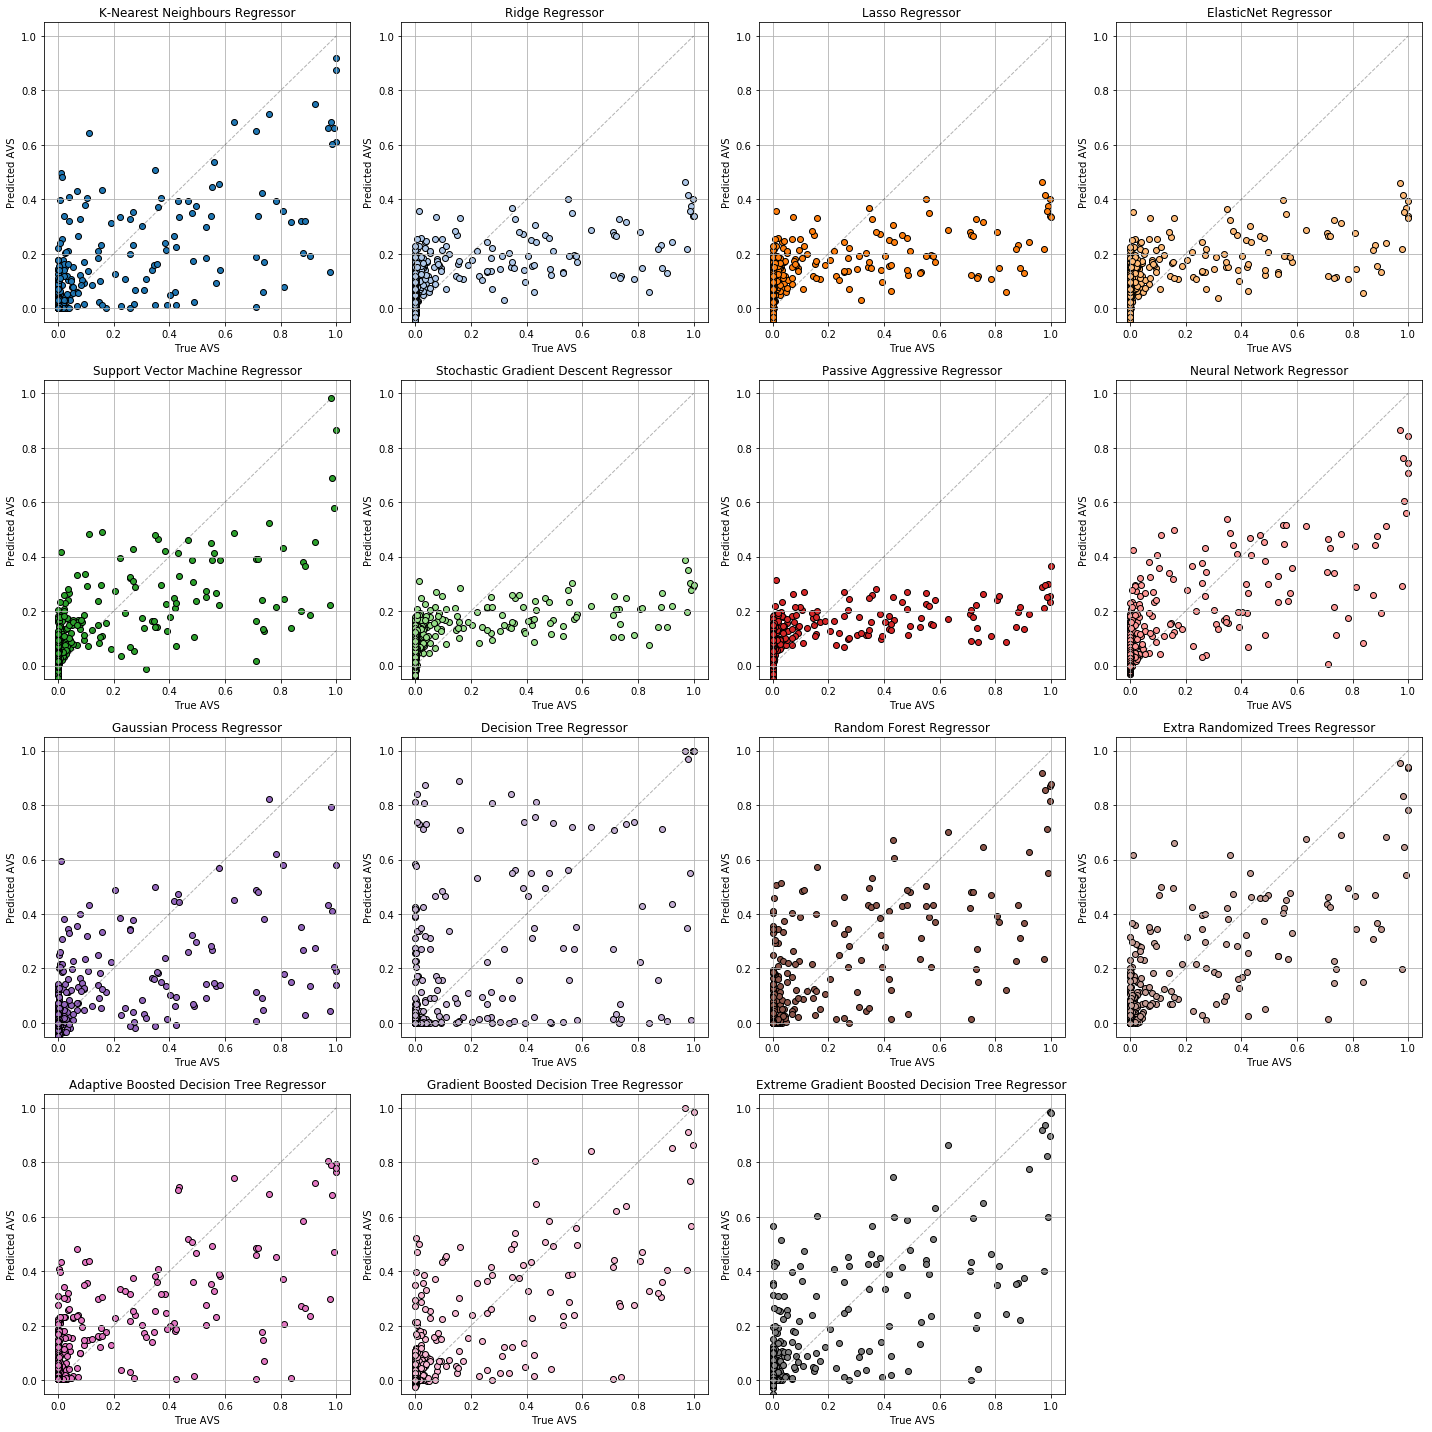


--> Regression metrics for all models (mean and std over all years):


,Estimator,R2 score,Explained variance score,Median absolute error,Mean absolute error,Mean squared error,Mean squared log error
0,K-Nearest Neighbours Regressor,0.574,0.575,0,0.0194,0.00644,0.00355
1,Ridge Regressor,0.329,0.329,0.0326,0.0543,0.0101,0.00607
2,Lasso Regressor,0.329,0.329,0.0327,0.0542,0.0101,0.00607
3,ElasticNet Regressor,0.33,0.33,0.0325,0.0541,0.0101,0.00604
4,Support Vector Machine Regressor,0.55,0.566,0.0237,0.042,0.0068,0.00408
5,Stochastic Gradient Descent Regressor,0.292,0.292,0.0369,0.0563,0.0107,0.00633
6,Passive Aggressive Regressor,0.262,0.265,0.0387,0.0584,0.0111,0.0067
7,Neural Network Regressor,0.62,0.62,0.00696,0.0265,0.00574,0.00319
8,Gaussian Process Regressor,0.436,0.441,0.000937,0.0239,0.00851,0.00455
9,Decision Tree Regressor,0.195,0.195,3.02e-05,0.0255,0.0122,0.00676


In [17]:
X_train = np.array(X_train) # To accommodate X_train = X_training[train_index] and X_test = X_training[test_index]
y_train = np.array(y_train) # To accommodate y_train = y_training[train_index] and y_test = y_training[test_index]

logo = LeaveOneGroupOut()

cv_groups = df_train['YEAR'] # Players in the same group (i.e. a single NBA season) have identical YEAR variables

cv_metrics = []

color=iter(plt.cm.tab20(np.linspace(0, 1, 20)))    

plt.figure(figsize=(20, 20))

for imodel, model in enumerate(models):
    
    model.reset()
    
    regressor      = model.estimator
    regressor_name = model.estimator_name
    
    cv_y_predictions = []
    cv_y_truths      = []
    cv_importances   = []
    
    print("--> Cross-validating", regressor_name, "...")
    
    for train_index, test_index in logo.split(X_train, y_train, groups=cv_groups):

        X_cvtrain = X_train[train_index]
        X_cvtest  = X_train[test_index]
        y_cvtrain = y_train[train_index]
        y_cvtest  = y_train[test_index]
                       
        regressor.fit(X_cvtrain, y_cvtrain)
    
        y_cvprediction = regressor.predict(X_cvtest) 
        y_cvtruth      = y_cvtest.tolist()
             
        cv_y_predictions = np.append(cv_y_predictions, y_cvprediction)
        cv_y_truths      = np.append(cv_y_truths     , y_cvtruth)
        
        if hasattr(model.estimator, "feature_importances_"):
            importances = regressor.feature_importances_
            cv_importances.append(importances)
    
    cv_metrics.append({'Estimator'                : regressor_name, 
                       'R2 score'                 : r2_score(cv_y_truths, cv_y_predictions),
                       'Explained variance score' : explained_variance_score(cv_y_truths, cv_y_predictions),
                       'Median absolute error'    : median_absolute_error(cv_y_truths, cv_y_predictions),
                       'Mean absolute error'      : mean_absolute_error(cv_y_truths, cv_y_predictions),
                       'Mean squared error'       : mean_squared_error(cv_y_truths, cv_y_predictions),
                       'Mean squared log error'   : mean_squared_log_error(cv_y_truths, cv_y_predictions)})
    
    model.cv_importances = cv_importances        
    model.cv_evs         = explained_variance_score(cv_y_truths, cv_y_predictions)
    
    plt.subplot(4, 4, imodel+1)

    plt.title(regressor_name)
    plt.xlabel("True AVS")
    plt.ylabel("Predicted AVS")
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.grid(True)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='black', alpha=.3)
    plt.scatter(cv_y_truths, cv_y_predictions, color=next(color), edgecolor='k')
    plt.tight_layout()
       
plt.show()
    
print("")
print("--> Regression metrics for all models (mean and std over all years):")

columnorder = ['Estimator', 'R2 score', 'Explained variance score', 'Median absolute error', 
               'Mean absolute error', 'Mean squared error', 'Mean squared log error']

pd.set_option('precision', 3)
#pd.set_option('display.float_format', '{:6.3f}'.format) # doesn't seem to work with display(df)
df_cv_metrics = pd.DataFrame(cv_metrics, columns=columnorder)
cm = sns.diverging_palette(240, 10, n=9, as_cmap=True)
subset = ['R2 score', 'Explained variance score']
df_cv_metrics_style = df_cv_metrics.style.background_gradient(subset=subset, cmap=cm, axis=0)
display(df_cv_metrics_style)

#### Conclusion: 

Unfortunately none of the regression models tested in this analysis are able to accurately predict the Player Award voting shares. This is due to the erratic relationship between AVS and other features in the analysis (and to a lesser degree to the small sample size of players with award votes). Nevertheless, models with an Explained-Variance Score greater than 0.25 are retained to make a final prediction:

In [18]:
rejected_models = [models[9]]

EVS_threshold = 0.25

rejected_models = []

for model in models:
    if model.cv_evs < EVS_threshold:
        rejected_models.append(model)
        print("--> {:48} is rejected".format(model.estimator_name))
    else:
        print("--> {:48} is accepted".format(model.estimator_name))

#models = [x for x in models if x not in rejected_models]

--> K-Nearest Neighbours Regressor                   is accepted
--> Ridge Regressor                                  is accepted
--> Lasso Regressor                                  is accepted
--> ElasticNet Regressor                             is accepted
--> Support Vector Machine Regressor                 is accepted
--> Stochastic Gradient Descent Regressor            is accepted
--> Passive Aggressive Regressor                     is accepted
--> Neural Network Regressor                         is accepted
--> Gaussian Process Regressor                       is accepted
--> Decision Tree Regressor                          is rejected
--> Random Forest Regressor                          is accepted
--> Extra Randomized Trees Regressor                 is accepted
--> Adaptive Boosted Decision Tree Regressor         is accepted
--> Gradient Boosted Decision Tree Regressor         is accepted
--> Extreme Gradient Boosted Decision Tree Regressor is accepted


Calculate feature importances of all fitted Decision Tree ensemble models:

In [19]:
df_importances = pd.DataFrame() #index=feature_names, columns=model_names)

for model in models:
    
    if hasattr(model.estimator, "feature_importances_"):
    
        #print("--> Calculating feature importances for", model.estimator_name, "...")
        
        cv_importances = model.cv_importances
        
        df_cvimportances = pd.DataFrame(cv_importances, columns=feature_names)
                        
        mean_cvimportances = np.mean(df_cvimportances, axis=0)
        std_cvimportances  = np.std (df_cvimportances, axis=0)
        
        for i in range(n_features):
            df_importances.loc[feature_names[i], model.estimator_name] = \
                "{:.2f} $\pm$ {:.2f}".format((mean_cvimportances[i]*100), (std_cvimportances[i]*100))

#print("")
print("--> Feature importances  of all models (mean +/- std over all CV years):")
df_importances.dropna(axis=1, how='all', inplace=True)
display(df_importances)

--> Feature importances  of all models (mean +/- std over all CV years):


,Decision Tree Regressor,Random Forest Regressor,Extra Randomized Trees Regressor,Adaptive Boosted Decision Tree Regressor,Gradient Boosted Decision Tree Regressor,Extreme Gradient Boosted Decision Tree Regressor
G,0.33 $\pm$ 0.38,0.87 $\pm$ 0.16,1.85 $\pm$ 0.17,0.72 $\pm$ 0.24,1.12 $\pm$ 0.41,5.77 $\pm$ 1.27
GS,0.73 $\pm$ 0.88,0.72 $\pm$ 0.14,1.75 $\pm$ 0.17,0.30 $\pm$ 0.16,0.82 $\pm$ 0.44,0.07 $\pm$ 0.13
MP/G,3.16 $\pm$ 2.03,1.95 $\pm$ 0.31,1.68 $\pm$ 0.14,2.88 $\pm$ 0.63,6.01 $\pm$ 1.69,8.22 $\pm$ 0.79
PTS/48,2.38 $\pm$ 1.44,4.53 $\pm$ 0.93,6.89 $\pm$ 0.74,4.38 $\pm$ 1.61,10.00 $\pm$ 1.48,10.06 $\pm$ 1.66
PER,53.40 $\pm$ 2.34,47.74 $\pm$ 2.85,22.44 $\pm$ 1.48,33.22 $\pm$ 4.40,10.75 $\pm$ 1.42,9.59 $\pm$ 1.09
TS%,4.20 $\pm$ 1.56,3.29 $\pm$ 0.57,3.26 $\pm$ 0.27,2.39 $\pm$ 0.56,3.92 $\pm$ 1.12,3.97 $\pm$ 0.85
TRB%,0.93 $\pm$ 0.96,1.27 $\pm$ 0.18,1.75 $\pm$ 0.21,0.86 $\pm$ 0.51,1.80 $\pm$ 0.68,1.81 $\pm$ 0.72
AST%,3.30 $\pm$ 1.49,2.20 $\pm$ 0.33,2.31 $\pm$ 0.20,4.05 $\pm$ 1.00,6.02 $\pm$ 1.75,6.43 $\pm$ 1.26
STL%,1.61 $\pm$ 1.07,1.21 $\pm$ 0.15,2.24 $\pm$ 0.22,0.75 $\pm$ 0.35,1.98 $\pm$ 0.55,2.21 $\pm$ 0.69
BLK%,0.74 $\pm$ 0.71,0.84 $\pm$ 0.15,1.75 $\pm$ 0.14,0.26 $\pm$ 0.14,3.28 $\pm$ 0.86,3.18 $\pm$ 0.76


## Model training and predictions

Fit all models to training data and use fitted models to predict the players' AVP voting share in *test_year*. Predicted vs true AVS distributions are plotted and regression metrics are calculated if award voting has been completed for *test_year*:

--> Fitting K-Nearest Neighbours Regressor ...
--> Fitting Ridge Regressor ...
--> Fitting Lasso Regressor ...
--> Fitting ElasticNet Regressor ...
--> Fitting Support Vector Machine Regressor ...
--> Fitting Stochastic Gradient Descent Regressor ...
--> Fitting Passive Aggressive Regressor ...
--> Fitting Neural Network Regressor ...
--> Fitting Gaussian Process Regressor ...
--> Fitting Decision Tree Regressor ...
--> Fitting Random Forest Regressor ...
--> Fitting Extra Randomized Trees Regressor ...
--> Fitting Adaptive Boosted Decision Tree Regressor ...
--> Fitting Gradient Boosted Decision Tree Regressor ...
--> Fitting Extreme Gradient Boosted Decision Tree Regressor ...


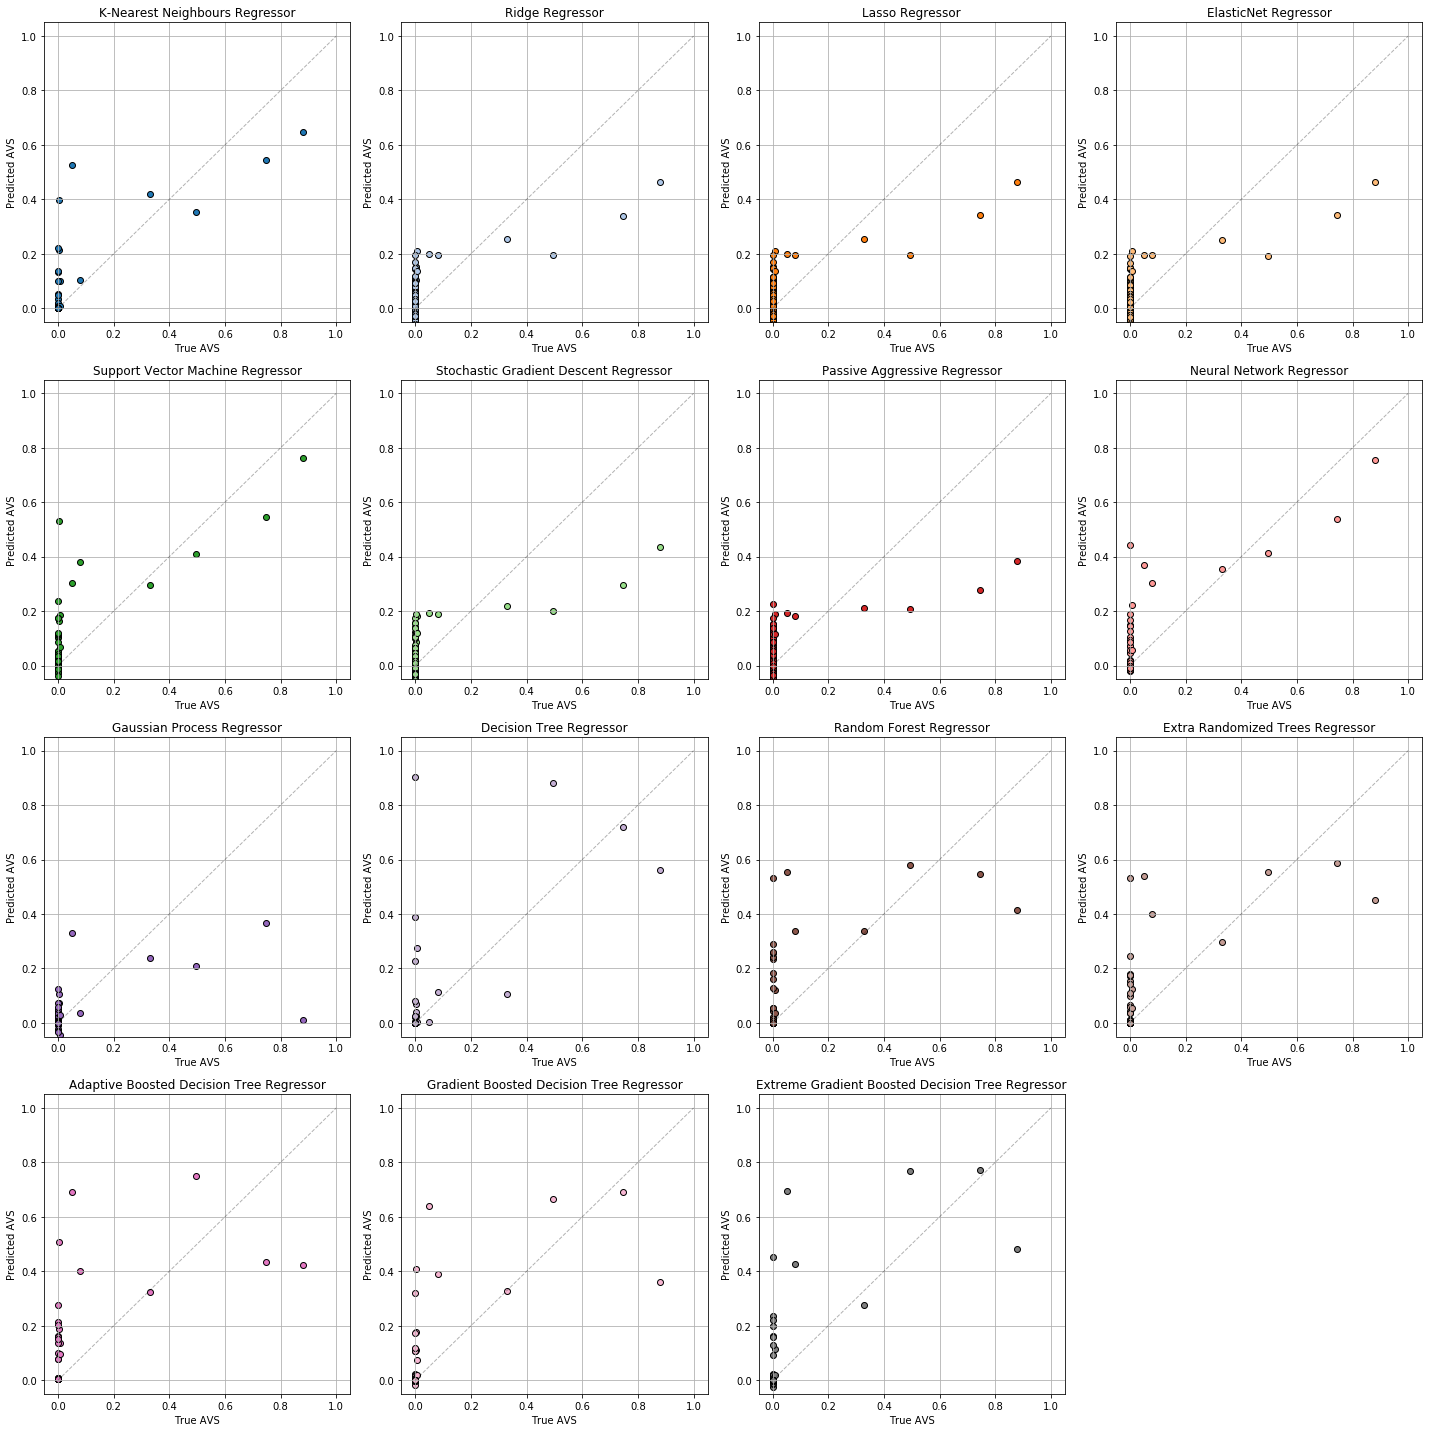


--> Regression metrics for all models:


,Estimator,R2 Score,Explained Variance Score,Median Absolute Error,Mean Absolute Error,Mean Squared Error,Mean Squared Log Error
0,K-Nearest Neighbours Regressor,0.592,0.606,0,0.026,0.007,0.004
1,Ridge Regressor,0.449,0.466,0.041,0.062,0.009,0.006
2,Lasso Regressor,0.45,0.467,0.041,0.062,0.009,0.006
3,ElasticNet Regressor,0.458,0.473,0.038,0.061,0.009,0.006
4,Support Vector Machine Regressor,0.499,0.587,0.023,0.05,0.008,0.006
5,Stochastic Gradient Descent Regressor,0.415,0.421,0.041,0.062,0.009,0.006
6,Passive Aggressive Regressor,0.332,0.336,0.05,0.069,0.011,0.007
7,Neural Network Regressor,0.61,0.639,0.007,0.035,0.006,0.005
8,Gaussian Process Regressor,0.306,0.311,0.001,0.029,0.011,0.006
9,Decision Tree Regressor,0.132,0.153,0,0.031,0.014,0.008


In [20]:
if test_year_truth_is_known:
    color=iter(plt.cm.tab20(np.linspace(0, 1, 20)))    
    plt.figure(figsize=(20, 20))

regression_metrics = []

for imodel, model in enumerate(models):
    
    regressor      = model.estimator
    regressor_name = model.estimator_name
    
    print("--> Fitting", regressor_name, "...")
    
    regressor.fit(X_train, y_train)          # Fit model to training data

    y_prediction = regressor.predict(X_test) # Predict test data
    
    model.set_y_prediction(y_prediction)
    
    if test_year_truth_is_known:

        #y_score = regressor.score(X_test, y_test) # i.e. r2 score
        #model.set_y_score(y_score)
    
        y_truth = y_test.tolist()
        model.set_y_truth(y_truth)
                
        r2_s                 = r2_score(y_truth, y_prediction)
        explained_variance_s = explained_variance_score(y_truth, y_prediction)
        median_absolute_e    = median_absolute_error(y_truth, y_prediction)
        mean_absolute_e      = mean_absolute_error(y_truth, y_prediction)
        mean_squared_e       = mean_squared_error(y_truth, y_prediction)
        mean_squared_log_e   = mean_squared_log_error(y_truth, y_prediction)
        
        regression_metrics.append({'Estimator'                : regressor_name, 
                                   'R2 Score'                 : r2_s                 .round(3),
                                   'Explained Variance Score' : explained_variance_s .round(3),
                                   'Median Absolute Error'    : median_absolute_e    .round(3),
                                   'Mean Absolute Error'      : mean_absolute_e      .round(3),
                                   'Mean Squared Error'       : mean_squared_e       .round(3),
                                   'Mean Squared Log Error'   : mean_squared_log_e   .round(3)})
        
        plt.subplot(4, 4, imodel+1)

        plt.title(regressor_name)
        plt.xlabel("True AVS")
        plt.ylabel("Predicted AVS")
        plt.xlim(-0.05, 1.05)
        plt.ylim(-0.05, 1.05)
        plt.grid(True)
        plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='black', alpha=.3)
        plt.scatter(y_truth, y_prediction, color=next(color), edgecolor='k')
        plt.tight_layout()
    
if test_year_truth_is_known:
    
    plt.show()
    
    print("")
    print("--> Regression metrics for all models:")
    columnorder = ['Estimator', 'R2 Score', 'Explained Variance Score', 'Median Absolute Error', 
                   'Mean Absolute Error', 'Mean Squared Error', 'Mean Squared Log Error']
    df_regression_metrics = pd.DataFrame(regression_metrics, columns=columnorder)
    cm = sns.diverging_palette(240, 10, n=9, as_cmap=True)
    df_regression_metrics_style = df_regression_metrics.style.background_gradient( \
        subset=['R2 Score', 'Explained Variance Score'], cmap=cm, axis=0)
    display(df_regression_metrics_style)

List Player Award candidates for all models, and add predicted AVS and corresponding ranks to *df_test*:

In [21]:
player_index_dict = {}

for i in range(n_players_test):
    player_name = df_test.iat[i,0]
    player_index_dict[player_name] = i

printlimit = 10
    
for imodel, model in enumerate(models):
            
    model_acronym = ''.join(c for c in model.estimator_name if c.isupper())
    column_name_score = '{} score'.format(model_acronym)
    column_name_rank  = '{} rank' .format(model_acronym)
    
    df_rank = pd.DataFrame(columns=['Player', column_name_rank], index=range(0,n_players_test))

    regressor    = model.estimator
    y_prediction = model.y_prediction
    
    df_test[column_name_score] = y_prediction
    
    player_score_dict = {}
    for i in range(n_players_test):
        player_score_dict[df_test.iat[i,0]] = y_prediction[i]

    sorted_player_score_dict = sorted(player_score_dict.items(), key=operator.itemgetter(1), reverse=True)
    
    print("==> Predicted top-{} {} vote shares in {} for {}:".format( \
        printlimit, award, test_year, model.estimator_name))
    print("")
    
    previous_rank  = 0
    previous_score = 1e10
    rank_increment = 0
    
    for i, (key, value) in enumerate(dict(sorted_player_score_dict).items(), 1):
        
        if (value < previous_score):
            rank = previous_rank + 1 + rank_increment
            rank_increment = 0
        else:
            rank = previous_rank
            rank_increment += 1
        previous_rank  = rank
        previous_score = value
        
        df_rank.loc[player_index_dict[key], 'Player'        ] = key
        df_rank.loc[player_index_dict[key], column_name_rank] = rank
        
        if (i <= printlimit):
            print("----> {:3}: {:24} = {:6.3f}".format(rank, key, value))
        
    df_test = pd.merge(df_test, df_rank, how='right', left_on=['Player'], right_on=['Player'])    
    print("")

==> Predicted top-10 MVP vote shares in 2017 for K-Nearest Neighbours Regressor:

---->   1: Russell Westbrook        =  0.646
---->   2: James Harden             =  0.543
---->   3: Stephen Curry            =  0.527
---->   4: LeBron James             =  0.421
---->   5: Kevin Durant             =  0.398
---->   6: Kawhi Leonard            =  0.355
---->   7: Chris Paul               =  0.220
---->   8: Anthony Davis            =  0.213
---->   9: Damian Lillard           =  0.139
---->  10: Rudy Gobert              =  0.132

==> Predicted top-10 MVP vote shares in 2017 for Ridge Regressor:

---->   1: Russell Westbrook        =  0.463
---->   2: James Harden             =  0.340
---->   3: LeBron James             =  0.253
---->   4: Giannis Antetokounmpo    =  0.211
---->   5: Stephen Curry            =  0.199
---->   6: Isaiah Thomas            =  0.197
---->   7: Jimmy Butler             =  0.196
---->   8: Kawhi Leonard            =  0.196
---->   9: Karl-Anthony Towns       =  0

Create Player Award candidate list with all AVS predictions and prediction ranks, sorted according to the median predicted rank over all selected models:

In [22]:
score_column_names = []
rank_column_names  = []
both_column_names  = []

for model in models:
    
    if model in rejected_models:
        continue
    
    model_acronym = ''.join(c for c in model.estimator_name if c.isupper())
    score_column_names.append("{} score".format(model_acronym))
    rank_column_names .append("{} rank" .format(model_acronym))
    both_column_names .append("{} score".format(model_acronym))
    both_column_names .append("{} rank" .format(model_acronym))

all_column_names = ['Player', 'Tm', 'G']
all_column_names.extend(both_column_names)

df_awardcandidates = df_test.filter(all_column_names, axis=1)

'''
# Scale all probability scores between 0 and 1:

scaler = MinMaxScaler(feature_range=(0, 1))

df_awardcandidates[score_column_names] = scaler.fit_transform(df_awardcandidates[score_column_names])

# Scale all probability score ranks between 1 and n_players_test:

scaler = MinMaxScaler(feature_range=(1, n_players_test))

df_awardcandidates[rank_column_names] = scaler.fit_transform(df_awardcandidates[rank_column_names])
'''

# Calculate median predicted AVS and median predicted rank of all non-rejected models:

df_test['Median AVS' ] = df_awardcandidates[score_column_names].median(axis=1)
df_test['Median rank'] = df_awardcandidates[rank_column_names ].median(axis=1)

df_awardcandidates['Median AVS' ] = df_awardcandidates[score_column_names].median(axis=1)
df_awardcandidates['Median rank'] = df_awardcandidates[rank_column_names ].median(axis=1)

if test_year_truth_is_known:
    df_awardcandidates['AVS'] = df_test['AVS']

#df_awardcandidates = df_awardcandidates.sort_values('Median AVS',  ascending=False)
df_awardcandidates = df_awardcandidates.sort_values('Median rank', ascending=True)

df_awardcandidates = df_awardcandidates.reset_index(drop=True)
df_awardcandidates.index = np.arange(1, len(df_awardcandidates) + 1)

print_limit = 10
#print("--> Predicted {} candidate top-{} in order of the median predicted AVS over all selected models:".format(
#    award, print_limit))
print("--> Predicted {} candidate top-{} in order of the median predicted rank over all selected models:".format(
    award, print_limit))
subset_scores = ['Median AVS', *score_column_names]
cm = sns.diverging_palette(240, 10, n=9, as_cmap=True)
df_awardcandidates_style = df_awardcandidates[:print_limit].style.background_gradient(subset=subset_scores, 
                                                                                      cmap=cm, axis=0)
display(df_awardcandidates_style)

--> Predicted MVP candidate top-10 in order of the median predicted rank over all selected models:


,Player,Tm,G,KNNR score,KNNR rank,RR score,RR rank,LR score,LR rank,ENR score,ENR rank,SVMR score,SVMR rank,SGDR score,SGDR rank,PAR score,PAR rank,NNR score,NNR rank,GPR score,GPR rank,RFR score,RFR rank,ERTR score,ERTR rank,ABDTR score,ABDTR rank,GBDTR score,GBDTR rank,EGBDTR score,EGBDTR rank,Median AVS,Median rank,AVS
1,Russell Westbrook,OKC,81,0.646,1,0.463,1,0.463,1,0.465,1,0.764,1,0.434,1,0.385,1,0.754,1,0.0101,20,0.414,5,0.451,5,0.421,5,0.361,6,0.482,4,0.457,1,0.879
2,James Harden,HOU,81,0.543,2,0.34,2,0.341,2,0.343,2,0.546,2,0.295,2,0.277,2,0.54,2,0.367,1,0.547,3,0.588,1,0.435,4,0.692,1,0.773,1,0.487,2,0.746
3,Kawhi Leonard,SAS,74,0.355,6,0.196,8,0.195,8,0.193,7,0.41,4,0.199,4,0.209,5,0.415,4,0.21,4,0.581,1,0.553,2,0.752,1,0.665,2,0.767,2,0.383,4,0.495
4,Stephen Curry,GSW,79,0.527,3,0.199,5,0.199,5,0.197,5,0.304,6,0.193,5,0.192,6,0.371,5,0.331,2,0.552,2,0.538,3,0.691,2,0.639,3,0.693,3,0.351,4,0.051
5,Kevin Durant,GSW,62,0.398,5,0.151,11,0.15,11,0.149,10,0.53,3,0.188,7,0.227,3,0.442,3,0.105,6,0.53,4,0.533,4,0.506,3,0.409,4,0.453,5,0.403,4.5,0.002
6,LeBron James,CLE,74,0.421,4,0.253,3,0.253,3,0.251,3,0.296,7,0.218,3,0.212,4,0.354,6,0.237,3,0.336,7,0.297,7,0.325,7,0.327,7,0.275,7,0.285,5,0.33
7,Isaiah Thomas,BOS,76,0.105,11,0.197,6,0.197,6,0.195,6,0.38,5,0.19,6,0.182,8,0.304,7,0.0355,12,0.339,6,0.4,6,0.403,6,0.391,5,0.427,6,0.251,6,0.08
8,Chris Paul,LAC,61,0.22,7,0.0597,29,0.0599,29,0.0655,28,0.239,8,0.156,11,0.153,10,0.188,9,0.0581,9,0.26,9,0.245,8,0.276,8,0.107,14,0.22,9,0.172,9,0
9,DeMarcus Cousins,NOP,72,0.101,12,0.143,13,0.144,13,0.147,12,0.176,10,0.174,9,0.176,9,0.167,10,0.0251,16,0.288,8,0.153,12,0.213,9,0.321,8,0.236,8,0.17,10,0
10,Anthony Davis,NOP,75,0.213,8,0.152,10,0.151,10,0.145,13,0.165,12,0.122,15,0.151,11,0.144,12,0.0739,8,0.236,12,0.174,11,0.188,11,0.178,9,0.2,10,0.158,11,0.002


Plot true AVS versus predicted AVS in the test data set if award voting has been completed for *test_year*:

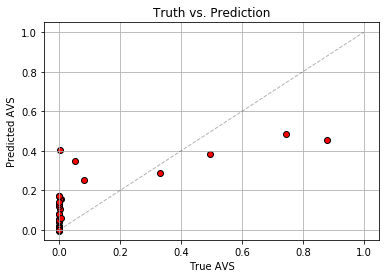

In [23]:
if test_year_truth_is_known:
    plt.title("Truth vs. Prediction")
    plt.xlabel('True AVS')
    plt.ylabel('Predicted AVS')
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.grid(True)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='black', alpha=.3)
    plt.scatter(df_test['AVS'], df_test['Median AVS'], color='r', edgecolor='k');
else:
    print("--> The NBA {} for {} has not been awarded yet".format(award, test_year))

Create interactive Bokeh plot using IPython/Jupyter widgets:

In [24]:
if not test_year_truth_is_known:
    print("--> The NBA {} for {} has not been awarded yet".format(award, test_year))
else:

    # Create Bokeh interactive tools:

    tools = "pan,wheel_zoom,box_zoom,reset,save".split(',')
    hover = HoverTool(tooltips=[
        ("Player", "@Player"),
        ("Team",   "@Tm"),
        ("Year",   "@YEAR"),
        ("PER",    "@PER"),
        ("VORP",   "@VORP"),
        ("WS/48",  "@{WS/48}"),
        ("PTS/48", "@{PTS/48}")
    ])
    tools.append(hover)

    # Create PTS/48 column:

    df_test[['PTS/48']] = df_test[['PTS']].div(df_test['MP'].values, axis=0)
    df_test[['PTS/48']] = df_test[['PTS/48']].multiply(48, axis=0)

    # Create color column according to AVS:

    palette = ["#053061", "#2166ac", "#4393c3", "#92c5de", "#d1e5f0",
               "#f7f7f7", "#fddbc7", "#f4a582", "#d6604d", "#b2182b", "#67001f"]

    avs = df_test["AVS"]
    low = min(avs)
    high = max(avs)
    avs_colorindices = [int(10*(x-low)/(high-low)) for x in avs] # colors range from 0 to 10
    df_test['avs_colors'] = [palette[i] for i in avs_colorindices]

    # Create Bokeh figure:

    p1 = figure(plot_width=700, plot_height=600, tools=tools, toolbar_location="above")
    p1.title.text = 'Interactive Bokeh plot using IPython/Jupyter widgets'
    p1.background_fill_color = "#dddddd"
    p1.grid.grid_line_color  = "white"

    equality_line = p1.line([0, 1], [0, 1], line_dash='dashed', line_width=1, color='black', alpha=.3)

    s1 = ColumnDataSource(data=df_test)

    c1 = p1.circle(x='AVS', y='Median AVS', source=s1,
                   size=12, color='avs_colors', line_color="black", fill_alpha=0.8)

    l1 = LabelSet(x='AVS', y='Median AVS', source=s1, 
                  text="Player", y_offset=8, text_align='center', text_font_size="8pt", text_color="#555555")
    p1.add_layout(l1)

    bokeh_handle = show(p1, notebook_handle=True)

    # Create IPython/Jupyter interact widget:

    def update(setx='AVS', sety='Median AVS'):    
        c1.data_source.data['AVS']        = df_test[setx].tolist()
        c1.data_source.data['Median AVS'] = df_test[sety].tolist()
        p1.xaxis.axis_label = setx
        p1.yaxis.axis_label = sety
        if (setx=='AVS') and (sety=='Median AVS'):
            equality_line.visible = True
        else:
            equality_line.visible = False
        push_notebook(handle=bokeh_handle)

    cols = df_test.columns
    
    ipywidgets.interact(update, setx=cols, sety=cols);

interactive(children=(Dropdown(description='setx', index=51, options=('Player', 'Pos', 'Age', 'Tm', 'G', 'GS',…

## Conclusion

The supervised non-linear regression algorithms tested in this analysis are able to predict the NBA awards reasonably well in terms of various regression metrics.

The Top-10 NBA Player Award candidates for *test_year* in order of the median predicted rank over all models:

In [25]:
print_nplayers = 10

print("--> Predicted Top-{} {} candidates {} :".format(print_nplayers, award, test_year))
print("")

for index, row in df_awardcandidates.iterrows():
    if (index <= print_nplayers):
        if test_year_truth_is_known:
            #print("{:2}) {:24} ({}) Median predicted AVS: {:5.3f} (Actual AVS = {:4.3f}, Games played: {})".format(
            #    index, row['Player'], row['Tm'], row['Median AVS'], row['AVS'], row['G']))
            print("{:2}) {:24} ({}) Median predicted rank: {:4.1f} (Actual AVS = {:4.3f}, Games played: {})".format(
                index, row['Player'], row['Tm'], row['Median rank'], row['AVS'], row['G']))
        else:
            #print("{:2}) {:24} ({}) Median predicted AVS: {:5.3f} (Actual AVS = N.A., Games played: {})".format(
            #    index, row['Player'], row['Tm'], row['Median MVS'], row['G']))
            print("{:2}) {:24} ({}) Median predicted rank: {:4.1f} (Actual AVS = N.A., Games played: {})".format(
                index, row['Player'], row['Tm'], row['Median rank'], row['G']))

--> Predicted Top-10 MVP candidates 2017 :

 1) Russell Westbrook        (OKC) Median predicted rank:  1.0 (Actual AVS = 0.879, Games played: 81)
 2) James Harden             (HOU) Median predicted rank:  2.0 (Actual AVS = 0.746, Games played: 81)
 3) Kawhi Leonard            (SAS) Median predicted rank:  4.0 (Actual AVS = 0.495, Games played: 74)
 4) Stephen Curry            (GSW) Median predicted rank:  4.0 (Actual AVS = 0.051, Games played: 79)
 5) Kevin Durant             (GSW) Median predicted rank:  4.5 (Actual AVS = 0.002, Games played: 62)
 6) LeBron James             (CLE) Median predicted rank:  5.0 (Actual AVS = 0.330, Games played: 74)
 7) Isaiah Thomas            (BOS) Median predicted rank:  6.0 (Actual AVS = 0.080, Games played: 76)
 8) Chris Paul               (LAC) Median predicted rank:  9.0 (Actual AVS = 0.000, Games played: 61)
 9) DeMarcus Cousins         (NOP) Median predicted rank: 10.0 (Actual AVS = 0.000, Games played: 72)
10) Anthony Davis            (NOP) Med

In [26]:
end = time.time()

print("--> Total processing time = {:.1f} secs".format((end - start)))

--> Total processing time = 184.7 secs
